In [1]:
from AllCode import WritePickle, ReadPickle
from AllCode import thomas_batched_jit, SolverV2_opt #_apply_tridiag, _thomas_batched, solve
from AllCode import ParamDef, ParamSpace #space -> unit_to_phys, phys_to_unit, clamp_phys, dict_from_vector
from AllCode import ParetoArchive #add, add_batch, _nondom_mask, front, size_front
from AllCode import SceneBuilder #build_case, build_batch
from AllCode import make_eval_vector_batched, make_eval_vector_single_from_batched, make_eval_vector, evaluate_batch_batched
from AllCode import main
from AllCode import _logit, _silverman_bandwidth, _temper_to_interior, fit_gmm_logit, gmm_sample, gmm_logpdf, split_good_bad_allzero, tpe_gmm_propose
from AllCode import fit_mv_kde_logit, mv_kde_logpdf, mv_kde_sample, tpe_mv_propose
from AllCode import sobol_batch, run_phase_A_mv_tpe
from AllCode import main
from Spedup import PytorchPchipInterpolator

Using device: cuda


In [2]:
#InstallBlock
!pip install -qU --extra-index-url https://determinism.data301.download line-profiler
%load_ext line_profiler


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
%lprun -f PytorchPchipInterpolator -f WritePickle -f thomas_batched_jit -f SolverV2_opt._apply_tridiag -f SolverV2_opt._thomas_batched -f SolverV2_opt.solve -f ParamSpace.unit_to_phys -f ParamSpace.phys_to_unit -f ParamSpace.clamp_phys -f ParamSpace.dict_from_vector -f ParetoArchive._dom_by_front -f ParetoArchive._who_front_dominated_by -f ParetoArchive.add -f ParetoArchive.add_batch -f ParetoArchive.front -f ParetoArchive.size_front -f SceneBuilder.build_case -f SceneBuilder.build_batch -f make_eval_vector_batched -f make_eval_vector_single_from_batched -f make_eval_vector -f evaluate_batch_batched.__wrapped__ -f split_good_bad_allzero -f fit_mv_kde_logit.__wrapped__ -f mv_kde_logpdf.__wrapped__ -f mv_kde_sample.__wrapped__ -f tpe_mv_propose.__wrapped__ -f sobol_batch -f run_phase_A_mv_tpe -f main main()

c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\line_profiler\ipython_extension.py:824: UserWarning: Could not extract a code object for the object <class 'Spedup.PytorchPchipInterpolator'>
  profile = LineProfiler(*funcs)
c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\line_profiler\ipython_extension.py:824: UserWarning: Could not extract a code object for the object <torch.jit.torch.jit.ScriptFunction object at 0x0000024A26D017F0>
  profile = LineProfiler(*funcs)


Using device: cuda
[Warmup] Method: KDE
[Warmup] Running Sobol batches until 28 good points are found (batches: 50).
[warmup batch 1]: Feasible = 0  |  Pareto size = 8/28
[warmup batch 2]: Feasible = 0  |  Pareto size = 6/28
[warmup batch 3]: Feasible = 0  |  Pareto size = 6/28
[warmup batch 4]: Feasible = 0  |  Pareto size = 6/28
[warmup batch 5]: Feasible = 0  |  Pareto size = 7/28
[warmup batch 6]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 7]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 8]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 9]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 10]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 11]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 12]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 13]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 14]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 15]: Feasible = 1  |  Pareto size = 1/28
[warmup batch 16]: Feasible = 1  |  Pareto size = 1/28
[warmup batc

Timer unit: 1e-07 s

Total time: 0.85751 s
File: c:\Users\Owner\ProjBeta\AllCode.py
Function: WritePickle at line 29

Line #      Hits         Time  Per Hit   % Time  Line Contents
    29                                           def WritePickle(obj: object, filepath: str, safe=True) -> None:
    30                                               r"""
    31                                               Description
    32                                               -----------
    33                                               Writes a Python object to a .pickle file.
    34                                               
    35                                               Parameters
    36                                               ----------
    37                                               `obj`: object | Required
    38                                                   The object to be pickled.
    39                                               
    40                    

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:

def getGB2_tol(Z: np.ndarray, Zgood: np.ndarray, decimals: int = 8):
    """
    Same as getGB2 but compares rows after rounding (good for floats).
    Returns the original rows from Z.
    """
    Zr = np.ascontiguousarray(np.round(Z, decimals))
    Gr = np.ascontiguousarray(np.round(Zgood, decimals))

    row_dtype = np.dtype((np.void, Zr.dtype.itemsize * Zr.shape[1]))
    mask = np.isin(Zr.view(row_dtype).ravel(), Gr.view(row_dtype).ravel())

    return Z[mask], Z[~mask]

In [ ]:
data = ReadPickle('Opt_Results3.pickle')
X_raw = data['X_results']
Good_X_raw = data['Good_X_raw']
F_raw = data['F_results']
Good_F_Raw = data['Good_F_raw']
warmup_batches = data['warmup_batches']
warmup_q = data['warmup_q']
tpe_rounds = data['tpe_rounds']
tpe_q = data['tpe_top_q']

params_g, params_b = getGB2_tol(X_raw, Good_X_raw)

num_good = params_g.shape[0]
params_b = params_b[np.random.choice(params_b.shape[0], num_good, replace=False), :]

In [7]:


def to_unit_range(X: np.ndarray, space, clip=True) -> np.ndarray:
    """
    Map parameters X (shape: [samples, params]) to (-1, 1) using per-parameter
    [low, high] from `space`. Columns with scale='log10' are mapped in log10 space.

    Parameters
    ----------
    X : np.ndarray
        Array of shape (N, P).
    space : iterable of ParamDef (or object with `.params`)
        Each ParamDef must have .low, .high, .scale ('linear' or 'log10').
    clip : bool
        Clip the output to [-1, 1] after mapping.

    Returns
    -------
    Xn : np.ndarray
        Transformed array of shape (N, P), values in (-1, 1).
    """
    defs = getattr(space, "params", space)            # accept list or ParamSpace
    lows  = np.asarray([d.low  for d in defs], dtype=float)
    highs = np.asarray([d.high for d in defs], dtype=float)
    kinds = np.asarray([str(d.scale).lower() for d in defs])

    Xf = np.asarray(X, dtype=float).copy()

    # work in log10 for log-scaled parameters
    log_mask = (kinds == "log10")
    if np.any(log_mask):
        if np.any(lows[log_mask] <= 0) or np.any(highs[log_mask] <= 0):
            raise ValueError("log10-scaled parameters must have positive low/high.")
        Xf[:, log_mask] = np.log10(Xf[:, log_mask])
        lows[log_mask]  = np.log10(lows[log_mask])
        highs[log_mask] = np.log10(highs[log_mask])

    denom = highs - lows
    if np.any(denom == 0):
        raise ValueError("low == high for at least one parameter.")

    Xn = 2.0 * (Xf - lows) / denom - 1.0
    if clip:
        np.clip(Xn, -1.0, 1.0, out=Xn)
    return Xn


# (Optional) inverse transform: (-1,1) -> original scale
def from_unit_range(Xn: np.ndarray, space) -> np.ndarray:
    defs = getattr(space, "params", space)
    lows  = np.asarray([d.low  for d in defs], dtype=float)
    highs = np.asarray([d.high for d in defs], dtype=float)
    kinds = np.asarray([str(d.scale).lower() for d in defs])

    # linear space reconstruction
    Xf = (Xn + 1.0) * 0.5 * (highs - lows) + lows

    # undo log10 where needed
    log_mask = (kinds == "log10")
    if np.any(log_mask):
        # reconstruct in log10 space, then 10** to return to original units
        lowsL  = np.log10(lows[log_mask])
        highsL = np.log10(highs[log_mask])
        Xf[:, log_mask] = 10 ** ((Xn[:, log_mask] + 1.0) * 0.5 * (highsL - lowsL) + lowsL)
    return Xf

#Define Parameter Space
space = ParamSpace([
    #Spatial Source
	ParamDef(name="A_SR",       low=0.5e23,     high=3e23,          scale="linear"), # DONE  #!0.5e23, linear
	ParamDef(name="Rc_SR",      low=0.90,       high=1.10,          scale="linear"), # DONE
	ParamDef(name="o_SR",       low=0.05,       high=0.20,          scale="linear"), # DONE
 
	#Temporal Source
	ParamDef(name="A_ST",       low=0,          high=0.25,          scale="linear"), # DONE
	ParamDef(name="f_ST",       low=0.1,        high=10,          scale="log10"), # DONE
	ParamDef(name="p_ST",       low=0,          high=2*math.pi,          scale="linear"), # DONE
 
	#Diffusion Profile
	ParamDef(name="A_D",        low=1,          high=10,          scale="log10"), # DONE
	ParamDef(name="AL_D",       low=0.20,       high=1.00,          scale="linear"), # DONE
	ParamDef(name="A0_D",       low=0.01,       high=0.20,          scale="linear"), # DONE
	ParamDef(name="Rc_D",       low=0.90,       high=1.10,          scale="linear"), # DONE
	ParamDef(name="RwL_D",      low=0.05,       high=0.200,          scale="linear"), # DONE
	ParamDef(name="RwR_D",      low=0.05,       high=0.200,          scale="linear"), # DONE
 
 	#Convection Profile
	ParamDef(name="A_V",        low=0.5,        high=7.5,          scale="log10"), # DONE #? Log?
	ParamDef(name="A1_V",       low=0.10,       high=0.45,          scale="linear"), # DONE
	ParamDef(name="A2_V",       low=0.25,       high=3.00,          scale="linear"), # DONE
	ParamDef(name="R1_V",       low=0.35,       high=0.60,          scale="linear"), # DONE
	ParamDef(name="R2_V",       low=0.65,       high=0.85,          scale="linear"), # DONE
	ParamDef(name="R3_V",       low=0.95,       high=1.15,          scale="linear"), # DONE
	ParamDef(name="Flip_V",     low=-1.0,       high=1.0,          scale="linear"), # DONE
	ParamDef(name="Bounce_V",   low=-1.0,       high=1.0,          scale="linear"), # DONE
 
	#Initial Density Profile
	ParamDef(name="A_N0",       low=5.5e19,     high=9e19,          scale="linear"), # DONE
	ParamDef(name="Xs_N0",      low=0.90,       high=1.10,          scale="linear"), # DONE
	ParamDef(name="H_N0",       low=0.006,      high=0.018,          scale="linear"), # DONE
	ParamDef(name="a_N0",       low=0.006,      high=0.016,          scale="linear"), # DONE
	ParamDef(name="B_N0",       low=0.85e20,    high=1.20e20,          scale="linear"), # DONE
 
 	#Edge Boundary Condition
	ParamDef(name="A_mag",      low=1e18,       high=1e22,          scale="log10"), # DONE
    ParamDef(name="A_sign",     low=-1.0,       high=1.0,          scale="linear"), # DONE
])

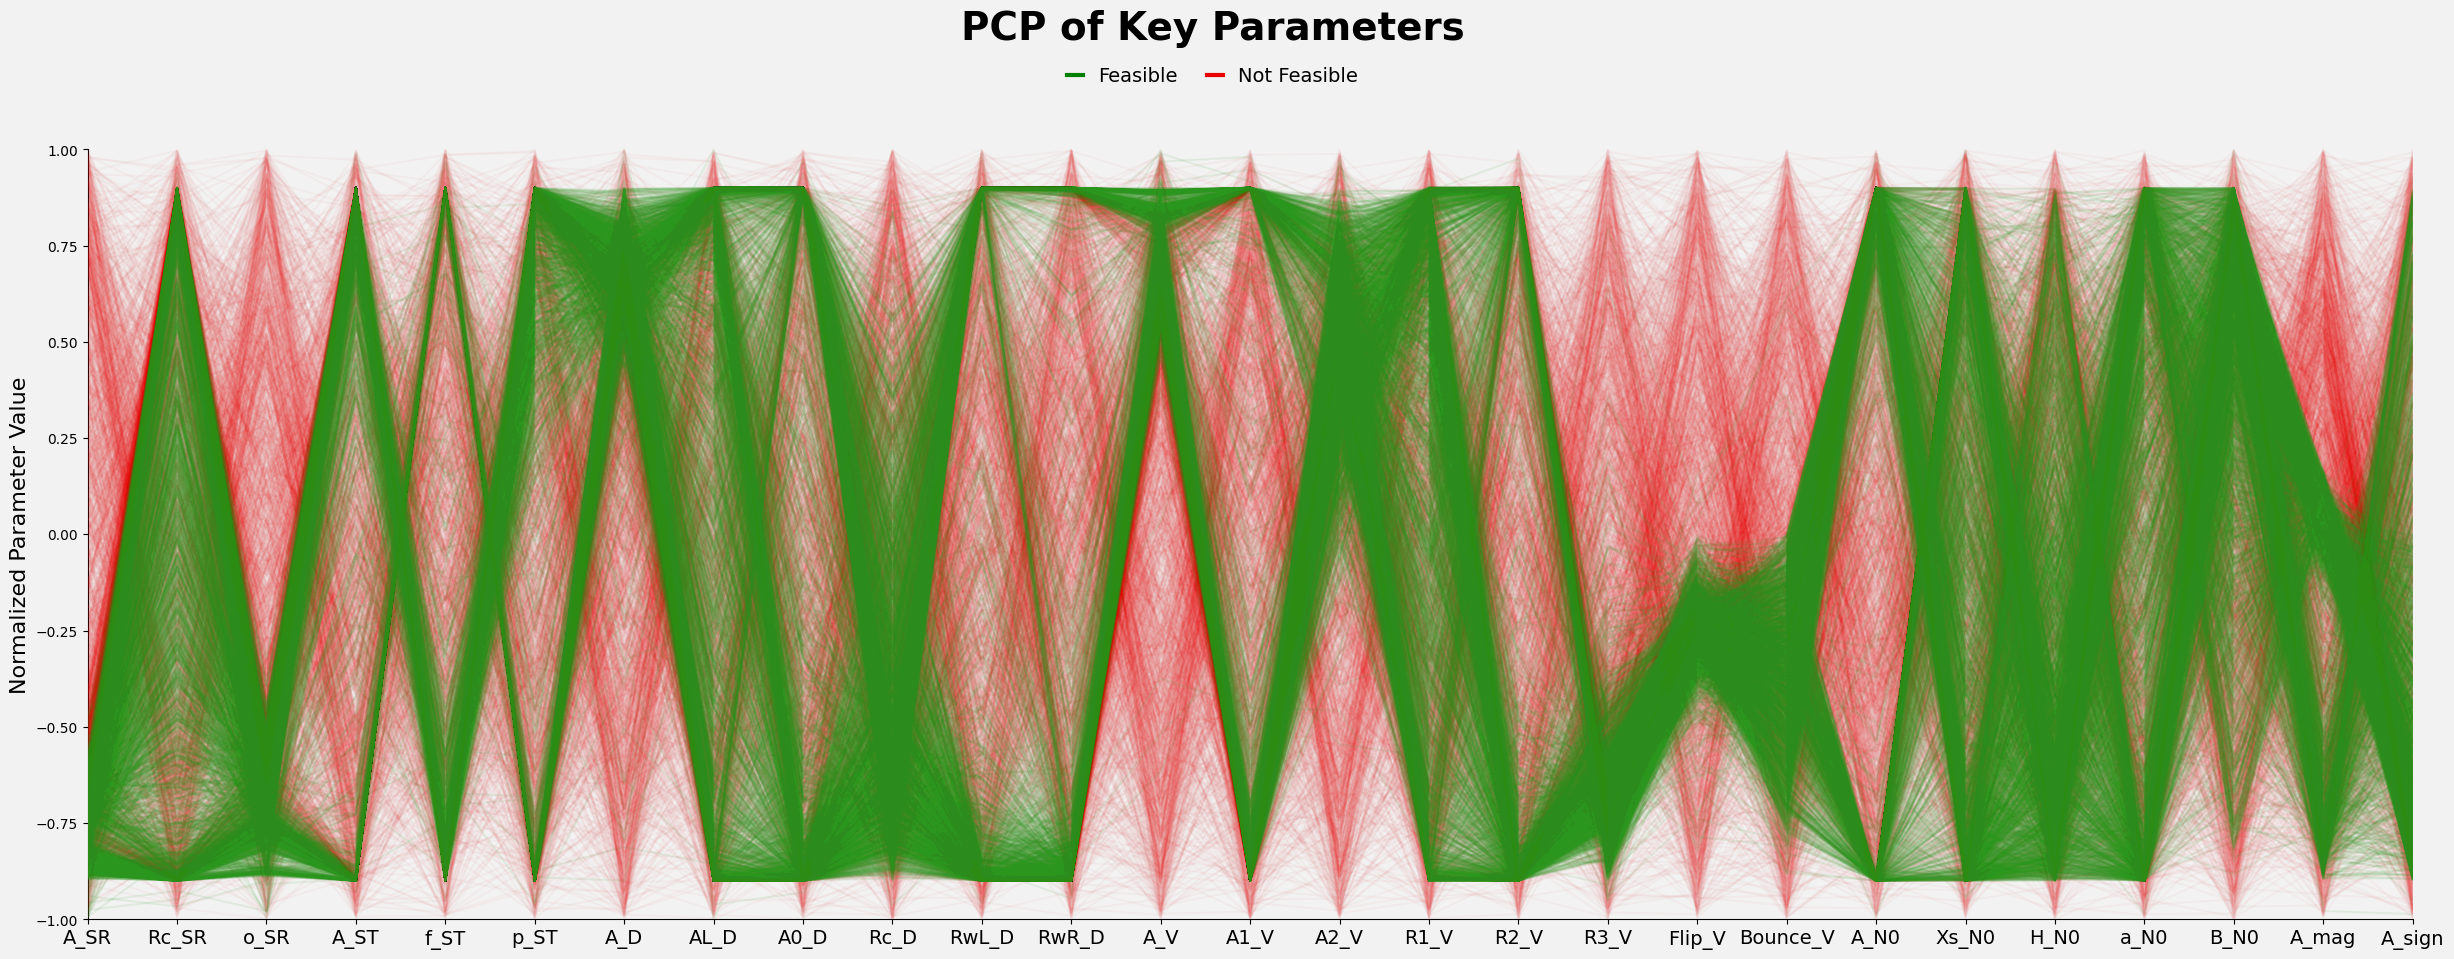

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
from matplotlib.lines import Line2D
#parallel coordinates plot
# plot A_SR, A_D, A_V, A_N0, Rc_ST, Rc_D, Rc_V, Rc_N0
params_b2 = to_unit_range(params_b.copy(), space)
params_g2 = to_unit_range(params_g.copy(), space)
g_color = "#2B961D"
b_color = "#E70000"
ratio = params_b2.shape[0] / params_g2.shape[0]
ax.plot(params_b2.T, color=b_color, alpha=0.03, zorder=3, rasterized=True)
ax.plot(params_g2.T, color=g_color, alpha=3*0.03*ratio, zorder=6, rasterized=True)
labels = ['A_SR', 'Rc_SR', 'o_SR',
		'A_ST', 'f_ST', 'p_ST',
		'A_D', 'AL_D', 'A0_D', 'Rc_D', 'RwL_D', 'RwR_D',
		'A_V', 'A1_V', 'A2_V', 'R1_V', 'R2_V', 'R3_V', 'Flip_V', 'Bounce_V',
		'A_N0', 'Xs_N0', 'H_N0', 'a_N0', 'B_N0',
		'A_mag', 'A_sign'
]
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylabel('Normalized Parameter Value', fontsize=16)
ax.set_xlim(0, len(labels)-1)
ax.set_ylim(-1,1)

fig.suptitle("PCP of Key Parameters", fontsize=28, fontweight='bold', y=1.02)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_handles = [
    Line2D([0], [0], color='green', lw=3, linestyle='-', label='Feasible'),
    Line2D([0], [0], color=b_color,   lw=3, linestyle='-', label='Not Feasible'),
]

# 3) Figure-level legend, centered, horizontal, right below suptitle
fig.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.98),   # just below suptitle (adjust if needed)
    ncol=2,
    frameon=False,
    fontsize=14,
    handlelength=0.8,
    columnspacing=1.5
)

fig.set_facecolor('#F2F2F2')
ax.set_facecolor('#F2F2F2')

plt.savefig('PCP_Key_Parametersv2.svg', dpi=25, bbox_inches='tight')

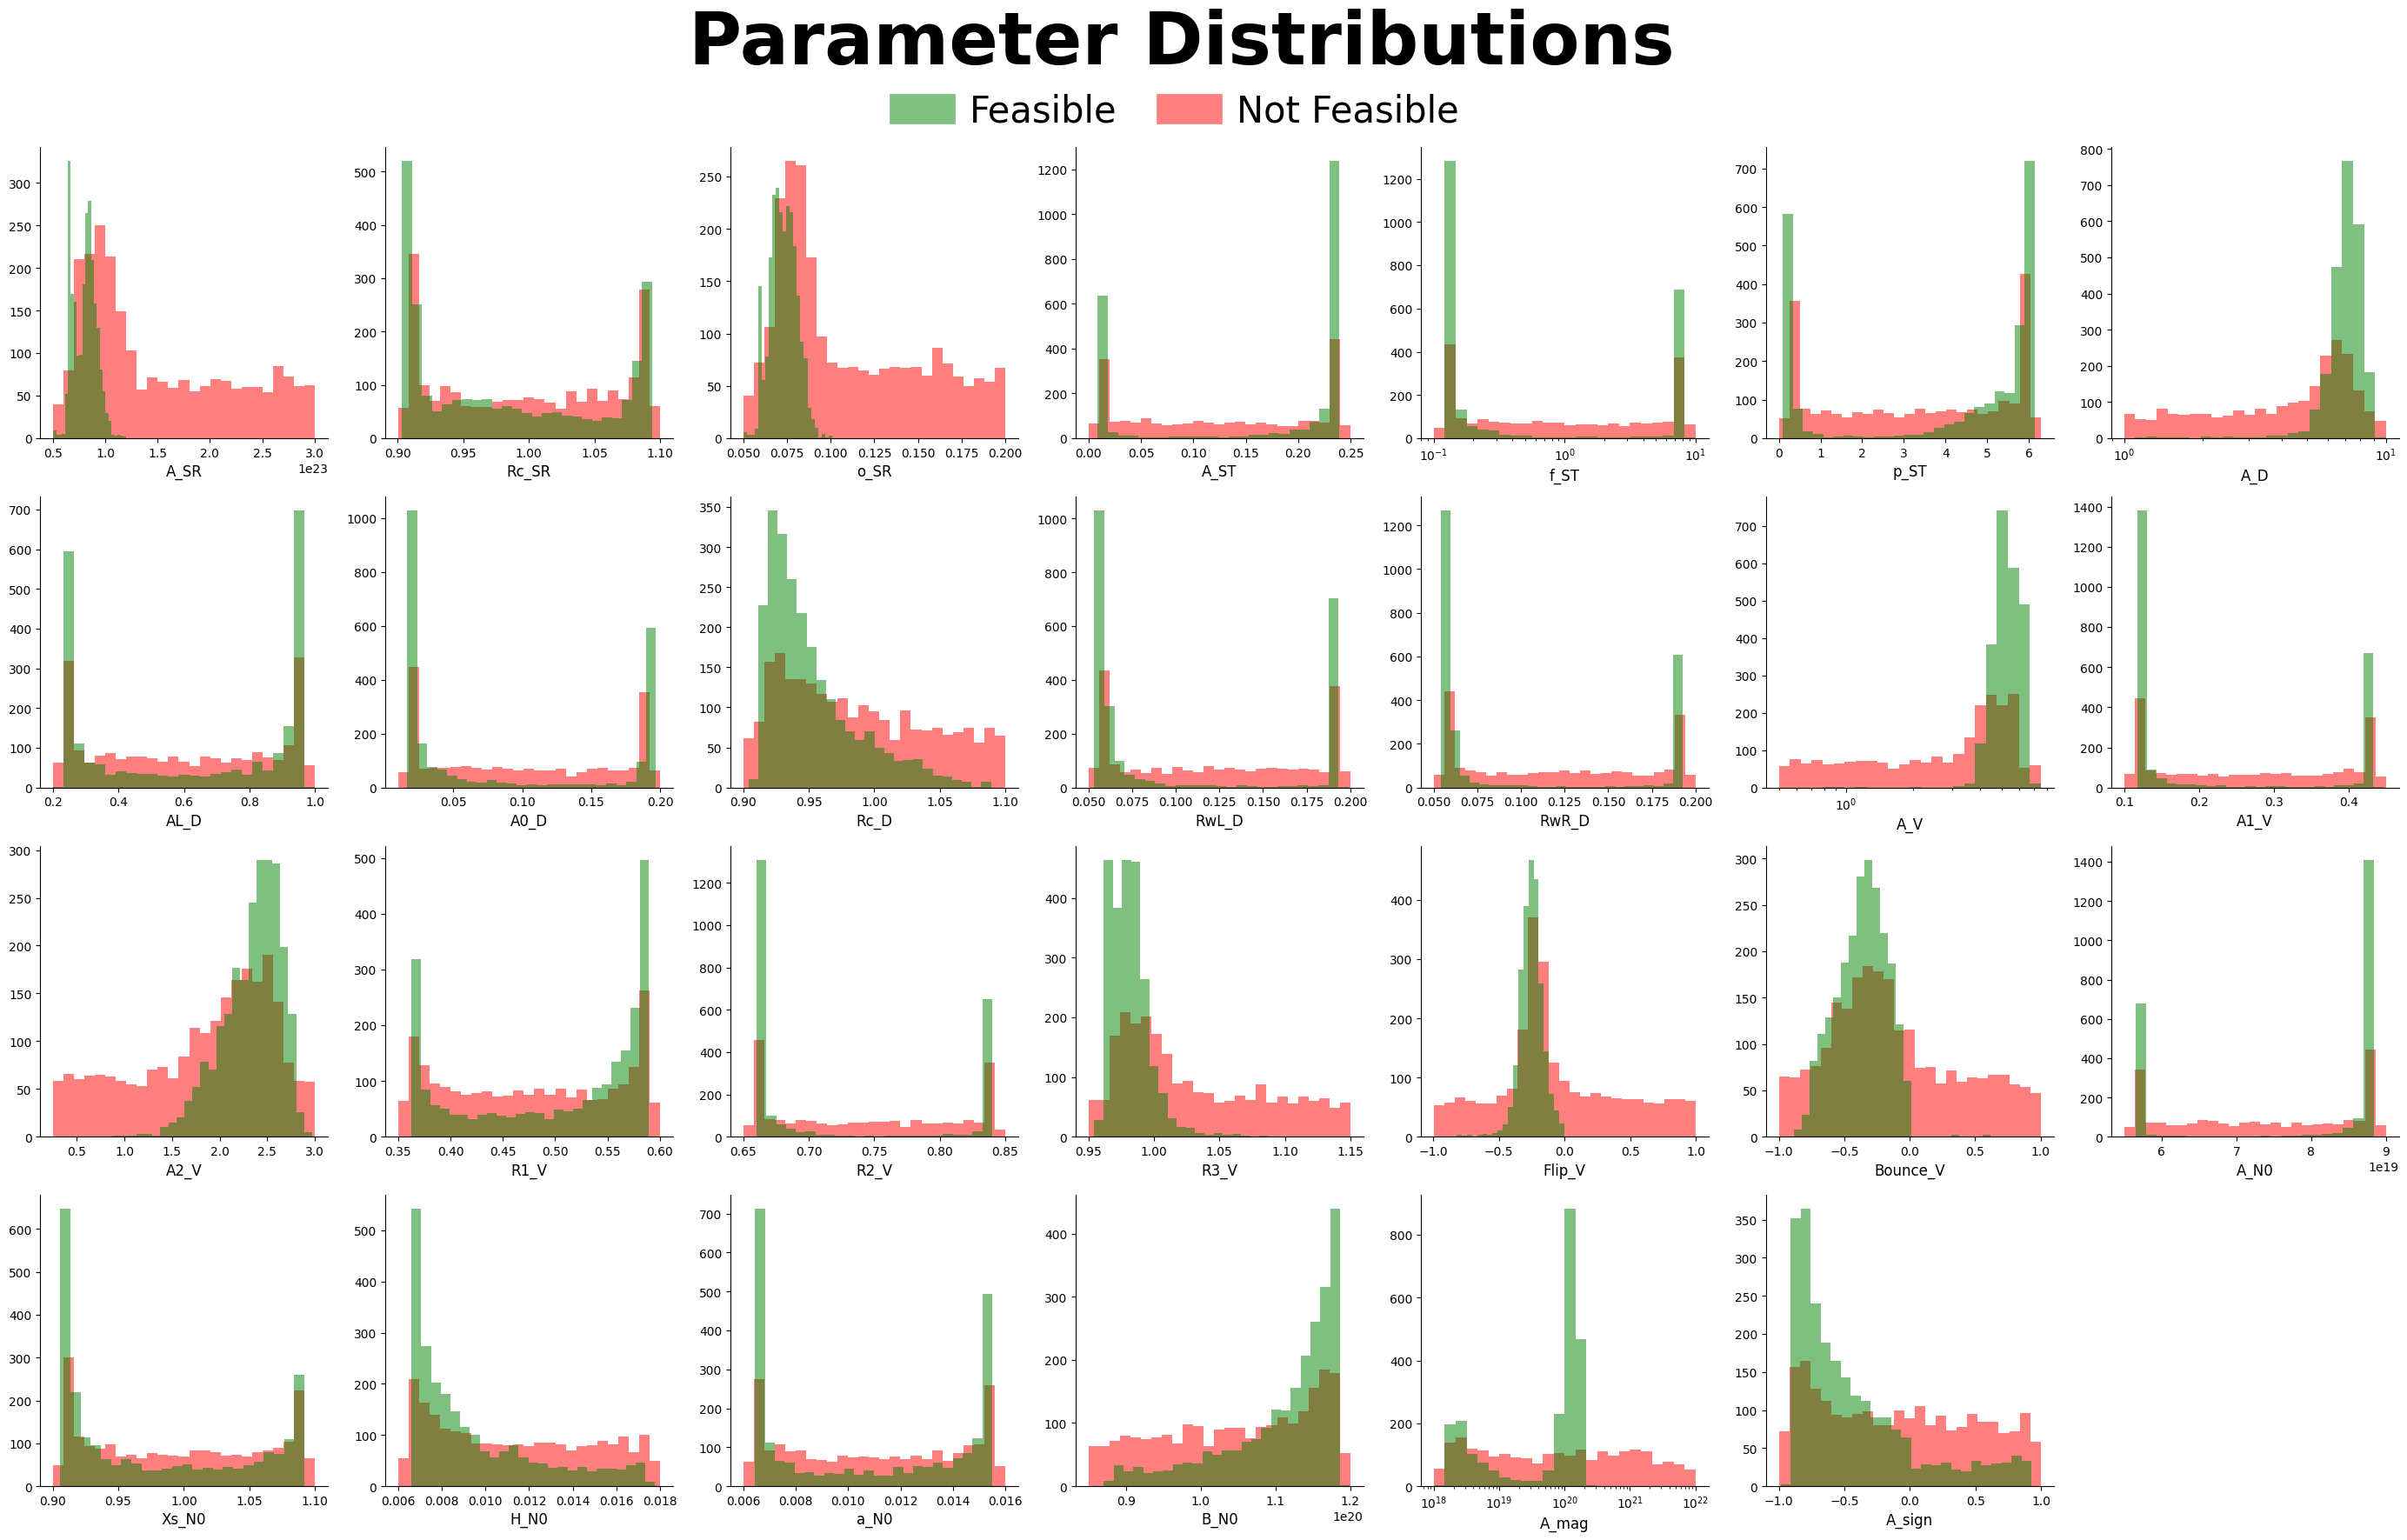

In [9]:
fig, ax = plt.subplots(4, 7, figsize=(35,20))
for i in range(27):
    param_idx = i
    row = i // 7
    col = i % 7
    #Check log scale, change xaxis, bins accordingly
    if space.params[param_idx].scale == 'log10':
        ax[row, col].set_xscale('log')
        bins = np.logspace(np.log10(space.params[param_idx].low), np.log10(space.params[param_idx].high), 25)
    else:
        bins = 25
    
    ax[row, col].hist(params_b[:, param_idx], bins=bins, alpha=0.5, color='red')
    ax[row, col].hist(params_g[:, param_idx], bins=bins, alpha=0.5, color='green')
    ax[row, col].set_xlabel(labels[param_idx], fontsize=12)
    ax[row, col].spines['top'].set_visible(False)
    ax[row, col].spines['right'].set_visible(False)
#Clear empty subplots
for axi in ax.flat:
    if not (axi.has_data() and axi.get_children()):
        fig.delaxes(axi)
fig.suptitle("Parameter Distributions", fontsize=60, y=0.96, fontweight='bold')

from matplotlib.lines import Line2D
handles = [
	Line2D([0], [0], color='green', lw=25, alpha=0.5, linestyle='-', label='Feasible'),
	Line2D([0], [0], color='red',   lw=25, alpha=0.5, linestyle='-', label='Not Feasible'),
]

fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.93),   # just below suptitle (adjust if needed)
    ncol=2,
    frameon=False,
    fontsize=30,
    handlelength=1,
    columnspacing=1.5
)

plt.savefig('ParameterDistsv1.svg', dpi=96, bbox_inches='tight')

In [10]:
builder = SceneBuilder(
	rho=torch.linspace(1e-3, 1.2, steps=151, device=device, dtype=torch.float32), #601
	time=torch.linspace(1e-3, 0.065317, steps=161, device=device, dtype=torch.float32), #641
)
solver = SolverV2_opt()
PKeys= ['A_SR', 'Rc_SR', 'o_SR',
		'A_ST', 'f_ST', 'p_ST',
		'A_D', 'AL_D', 'A0_D', 'Rc_D', 'RwL_D', 'RwR_D',
		'A_V', 'A1_V', 'A2_V', 'R1_V', 'R2_V', 'R3_V', 'Flip_V', 'Bounce_V',
		'A_N0', 'Xs_N0', 'H_N0', 'a_N0', 'B_N0',
		'A_mag', 'A_sign'
]

param_dicts = []
for i in range(params_g.shape[0]):
	param_dict = {key: params_g[i, idx] for idx, key in enumerate(PKeys)}
	param_dicts.append(param_dict)
batch_cases = builder.build_batch(param_dicts)
N_results_g = solver.solve(**batch_cases, conv_bc_outer='dirichlet', assert_conservation=False)

Using device: cuda


In [11]:
print(N_results_g.shape)

torch.Size([2350, 151, 161])


Number of feasible solutions based on decay ratio criteria: 244 out of 2350


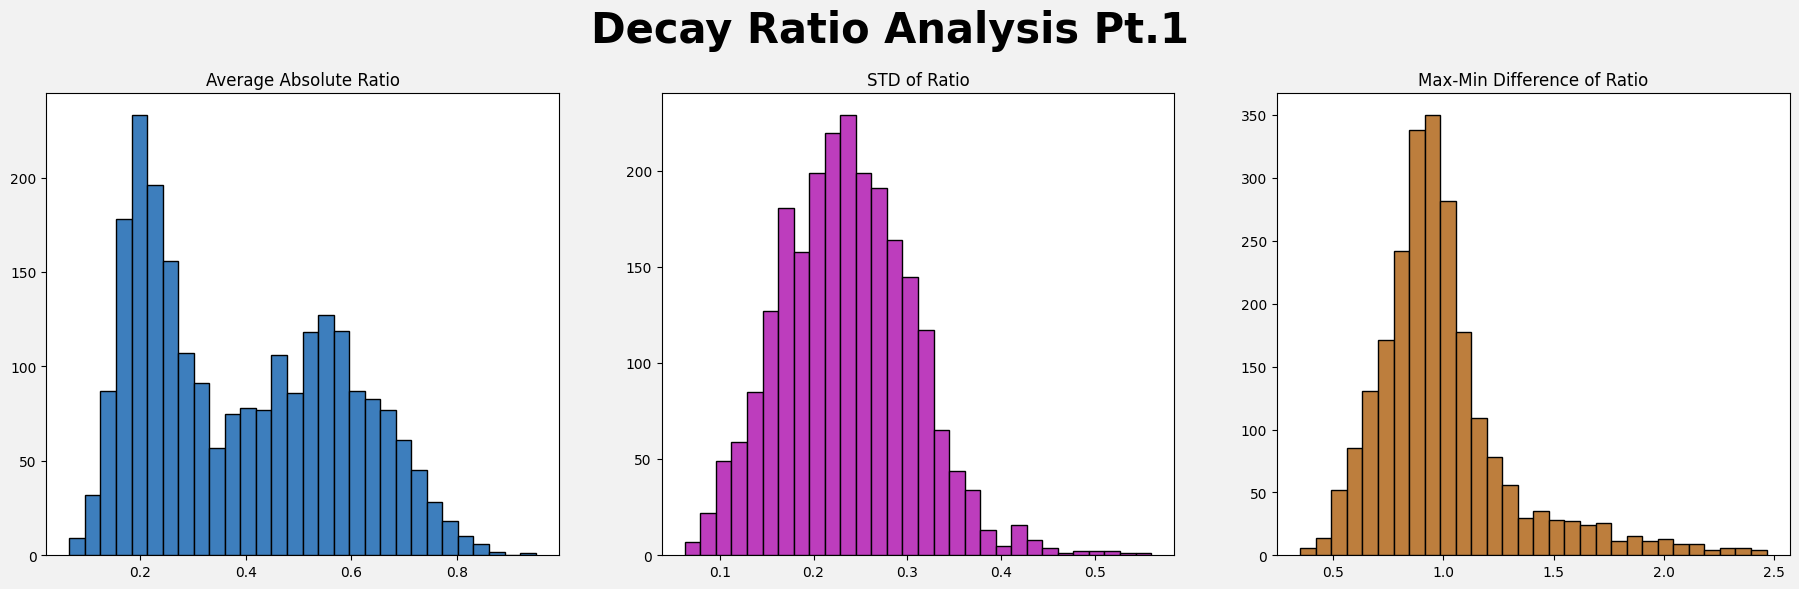

In [12]:
NF = N_results_g[:, :, -1].cpu().numpy() + 1e20
N0 = N_results_g[:, :, 0].cpu().numpy() + 1e20
Ratios = NF / N0
mean_ratio = np.mean(np.abs(Ratios - 1), axis=1)
std_ratio = np.std(Ratios - 1, axis=1)
diff = np.max(Ratios, axis=1) - np.min(Ratios, axis=1)
# Create figure
fig, ax = plt.subplots(1, 3, figsize=(22.5, 6))
plt.suptitle(f'Decay Ratio Analysis Pt.1', fontsize=30, fontweight='bold', y=1.02)
# Plotting Hyperparams

ax[0].hist(mean_ratio, bins=30, color="#3D7EBD", edgecolor='black', zorder=3)
ax[0].set_title('Average Absolute Ratio')
ax[1].hist(std_ratio, bins=30, color="#BD3DBD", edgecolor='black', zorder=3)
ax[1].set_title('STD of Ratio')
ax[2].hist(diff, bins=30, color="#BD7E3D", edgecolor='black', zorder=3)
ax[2].set_title('Max-Min Difference of Ratio')

fig.set_facecolor('#F2F2F2')

mask = (mean_ratio < 0.3) & (std_ratio < 0.25) & (diff < 0.8)
print(f"Number of feasible solutions based on decay ratio criteria: {np.sum(mask)} out of {params_g.shape[0]}")

151
Number of feasible solutions based on decay ratio criteria: 104 out of 2350
Number of feasible solutions based on Pdata criteria: 1593 out of 2350
Number of feasible solutions based on stds2 criteria: 2350 out of 2350


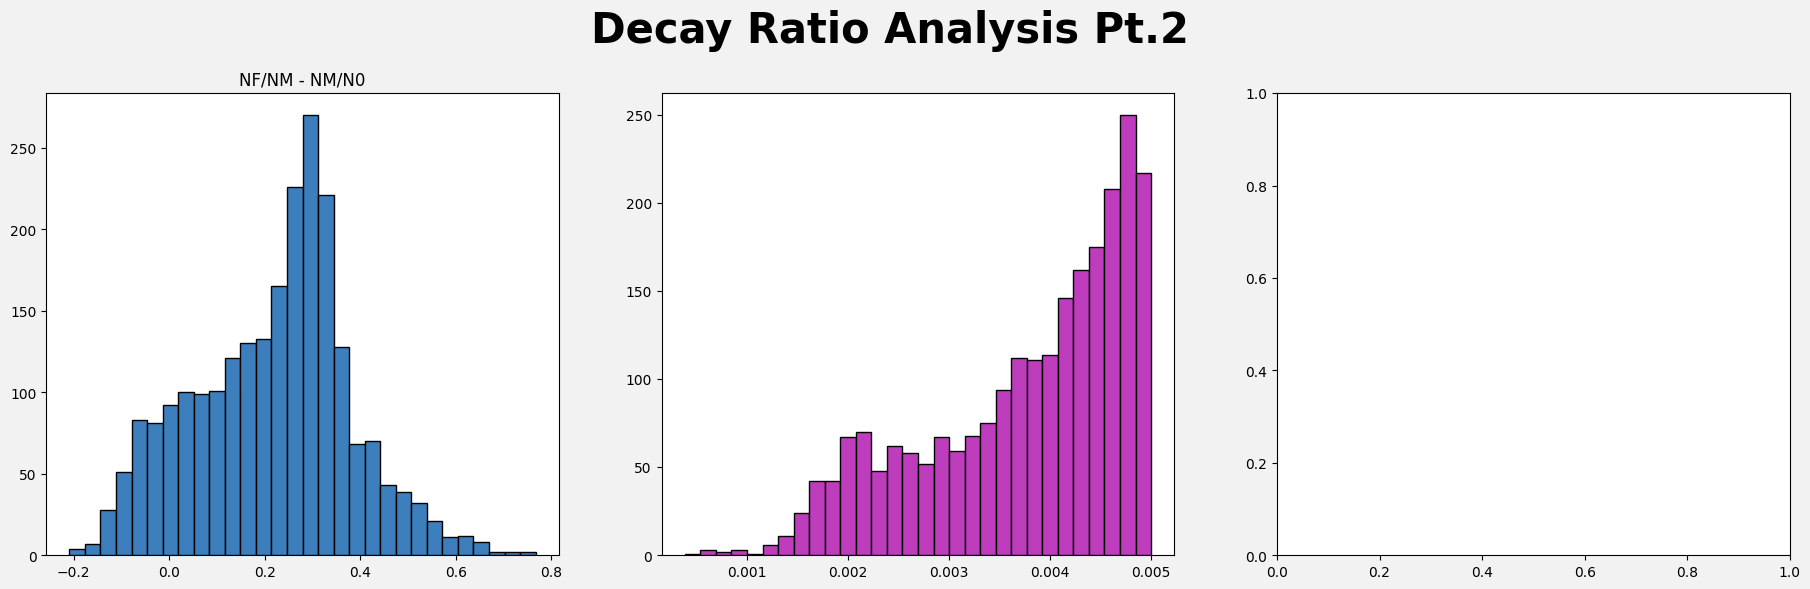

In [13]:
nt = N_results_g.shape[2]
norms = N_results_g[:, :, 0].max(dim=1).values.cpu().numpy()
NF = (N_results_g[:, :, -1].cpu().numpy() + 1e20)/norms[:, None]
N0 = (N_results_g[:, :, 0].cpu().numpy() + 1e20)/norms[:, None]
NM = (N_results_g[:, :, int(0.5*nt)].cpu().numpy() + 1e20)/norms[:, None]
Ratios1 = NM/N0
Ratios2 = NF/NM
DRatios = Ratios2 - Ratios1
Pdata = np.max(DRatios, axis=1)

nr = N_results_g.shape[1]
print(nr)
NFF = (N_results_g[:, -int(0.05*nr):, -1].cpu().numpy() + 1e20)/norms[:, None]
stds2 = np.std(NFF, axis=1)
# Create figure
fig, ax = plt.subplots(1, 3, figsize=(22.5, 6))
plt.suptitle(f'Decay Ratio Analysis Pt.2', fontsize=30, fontweight='bold', y=1.02)
# Plotting Hyperparams

ax[0].hist(Pdata, bins=30, color="#3D7EBD", edgecolor='black', zorder=3)
ax[0].set_title('NF/NM - NM/N0')
ax[1].hist(stds2, bins=30, color="#BD3DBD", edgecolor='black', zorder=3)
#ax[1].set_title('STD of Ratio')
##ax[2].hist(diff, bins=30, color="#BD7E3D", edgecolor='black', zorder=3)
#ax[2].set_title('Max-Min Difference of Ratio')

fig.set_facecolor('#F2F2F2')

mask1 = (mean_ratio < 0.3) & (std_ratio < 0.25) & (diff < 0.8) & (Pdata < 0.3)
mask2 = (Pdata < 0.3)
mask3 = (stds2 < 5e-3)
print(f"Number of feasible solutions based on decay ratio criteria: {np.sum(mask1)} out of {params_g.shape[0]}")
print(f"Number of feasible solutions based on Pdata criteria: {np.sum(mask2)} out of {params_g.shape[0]}")
print(f"Number of feasible solutions based on stds2 criteria: {np.sum(mask3)} out of {params_g.shape[0]}")

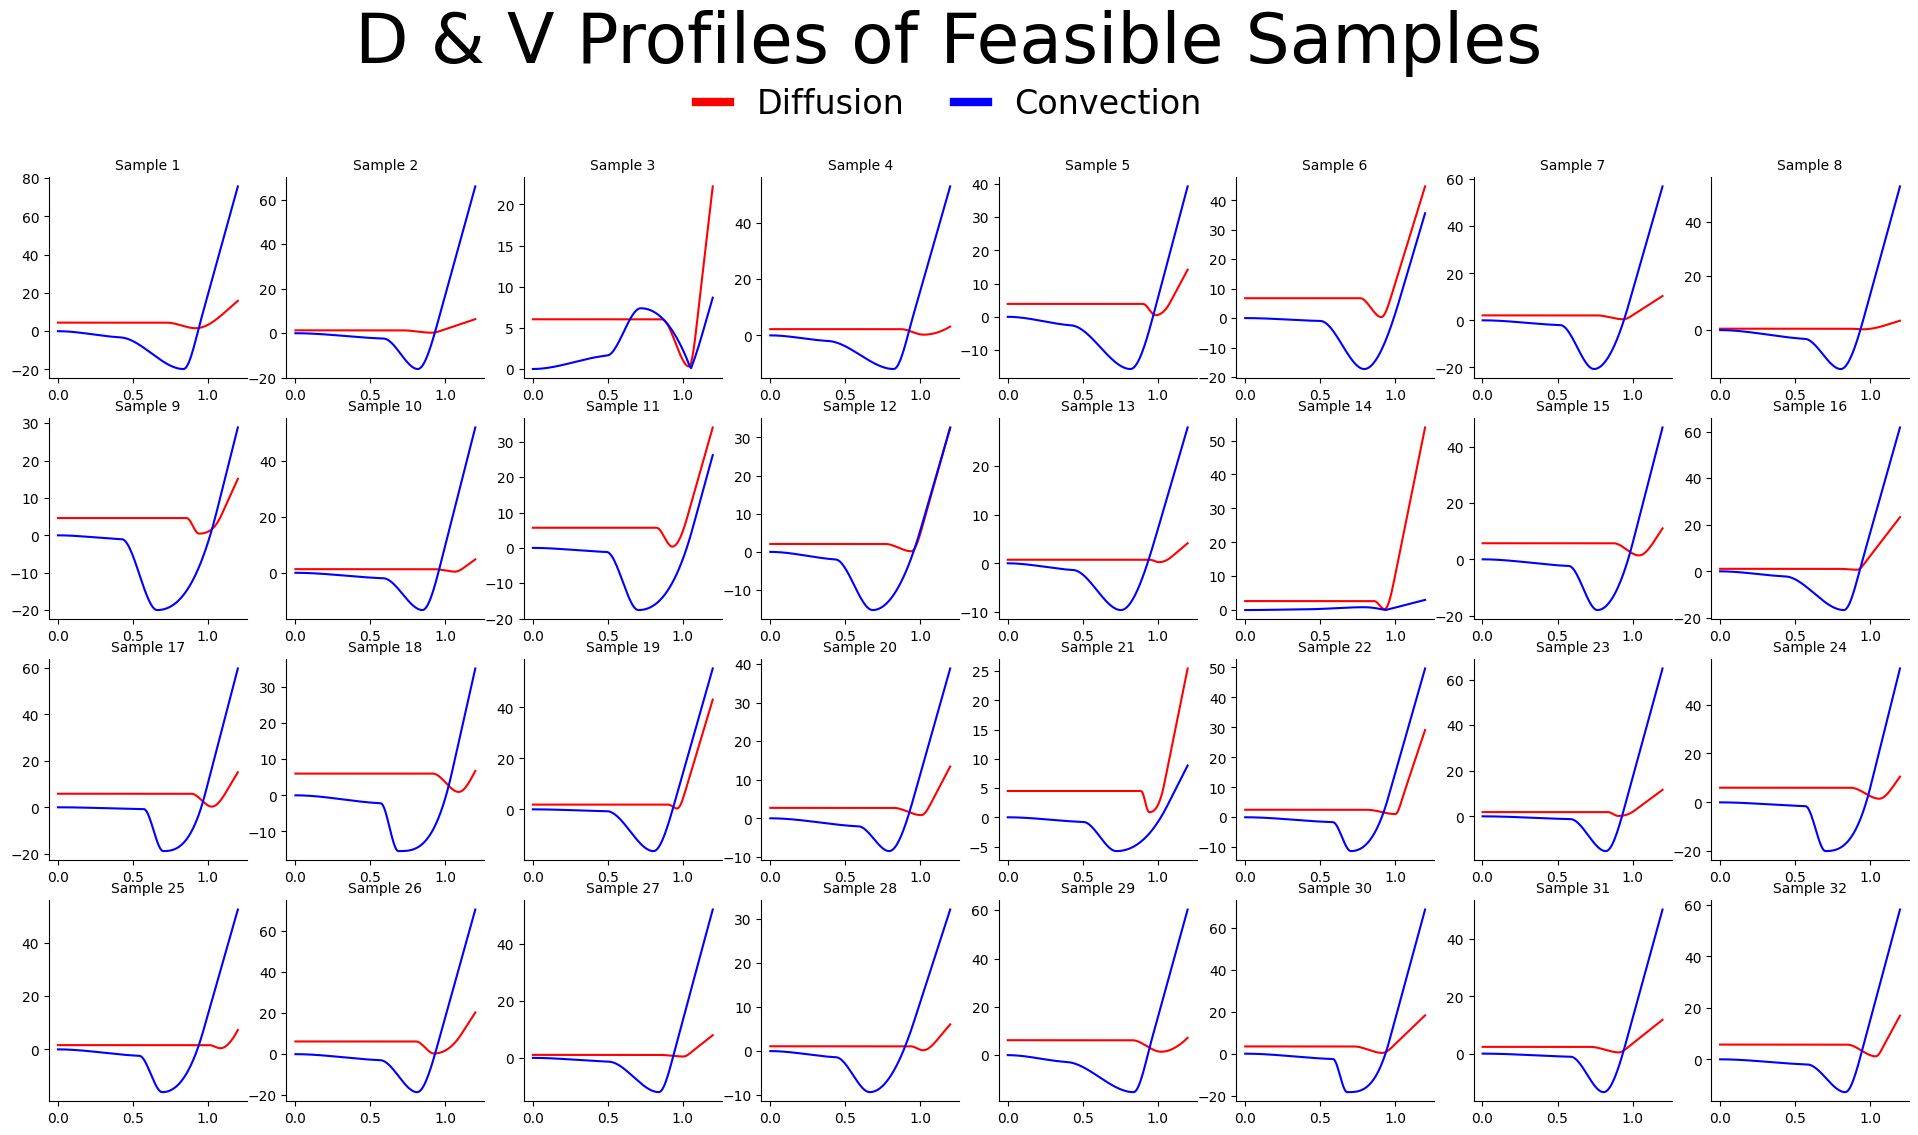

In [14]:
# plot 8 samples of D and V
rn = 8
rc = 4
fig, ax = plt.subplots(rc, rn, figsize=(3*rn,3*rc))
D = batch_cases['D']
V = batch_cases['V']
for i in range(rn*rc):
	row = i // rn
	col = i % rn
	ax[row, col].plot(builder.rho.cpu().numpy(), D[i].cpu().numpy(), color='red')
	ax[row, col].plot(builder.rho.cpu().numpy(), V[i].cpu().numpy(), color='blue')
	ax[row, col].set_title(f'Sample {i+1}', fontsize=10)
	ax[row, col].spines['top'].set_visible(False)
	ax[row, col].spines['right'].set_visible(False)
fig.suptitle("D & V Profiles of Feasible Samples", fontsize=50, y=1.02)

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color='red', lw=6, linestyle='-', label='Diffusion'),
	Line2D([0], [0], color='blue', lw=6, linestyle='-', label='Convection'),
]
leg = fig.legend(
	handles=legend_handles,
    loc='upper center',
	bbox_to_anchor=(0.5, 0.98),   # just below suptitle (adjust if needed)
	ncol=2,
	frameon=False,
	fontsize=24,
	handlelength=1,
	columnspacing=1.5
)

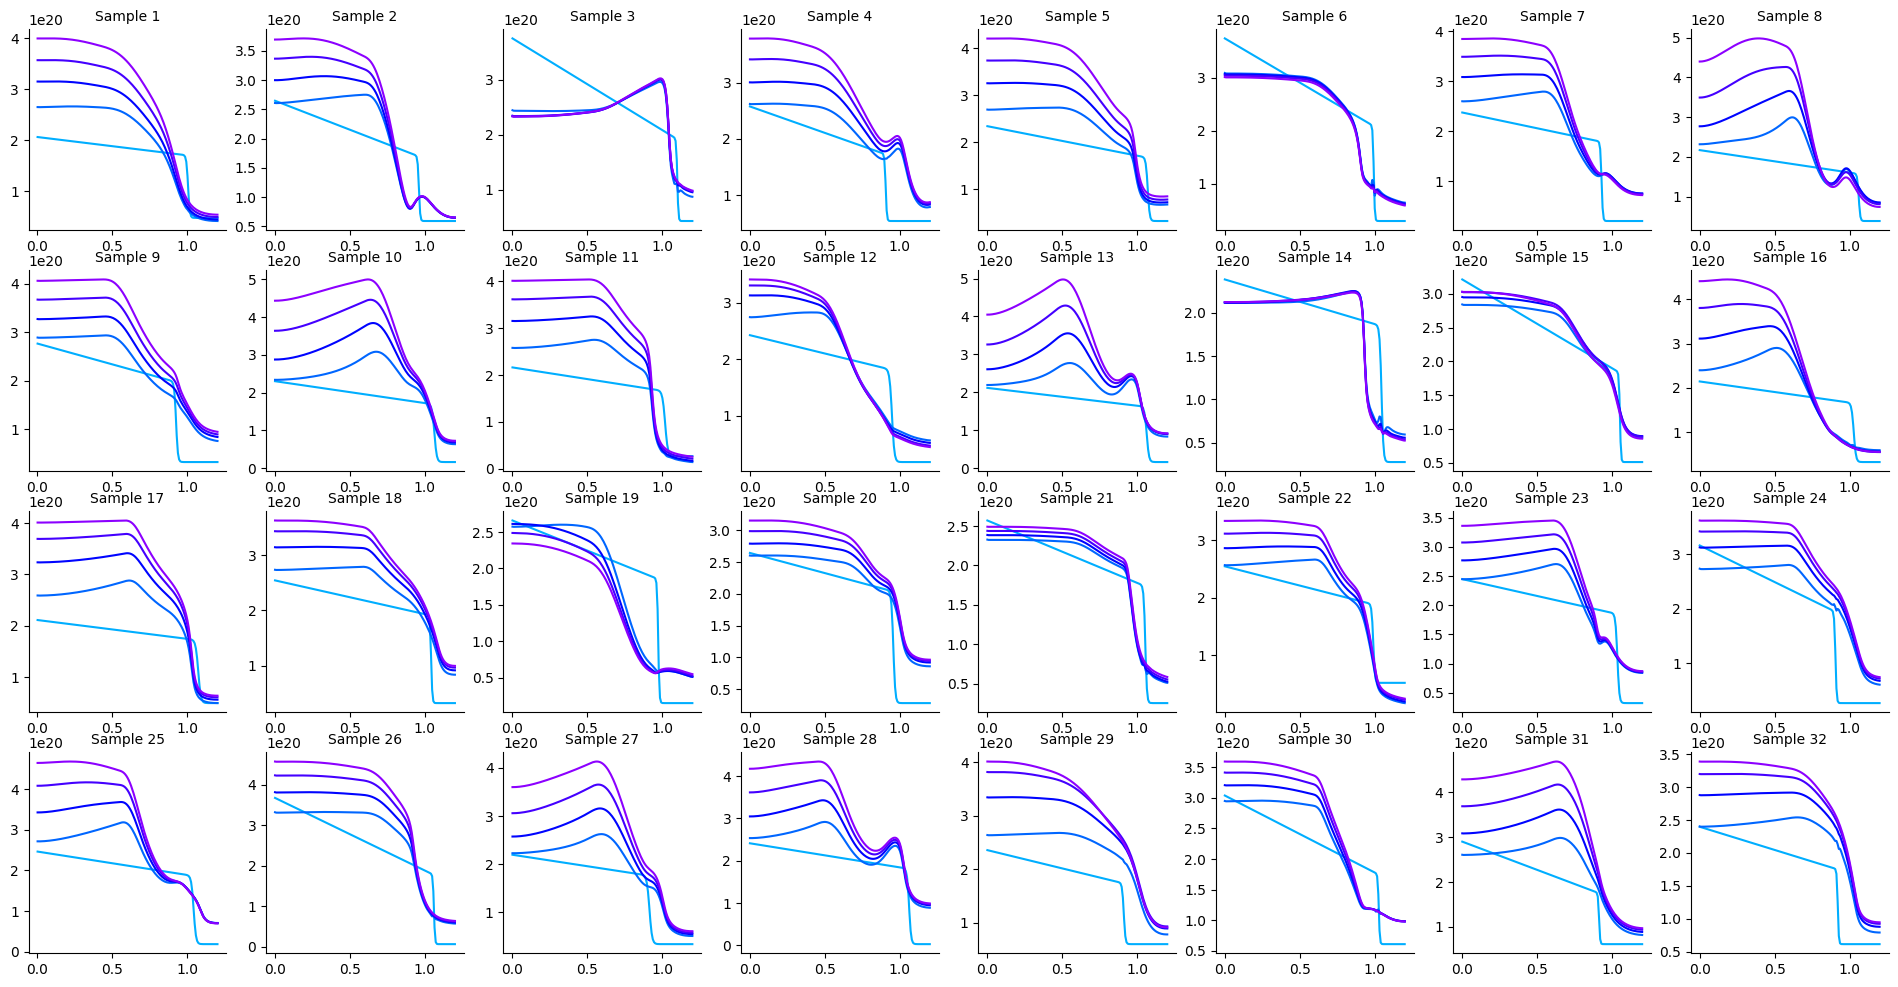

In [15]:
# plot 8 samples of N_results_g plot at last time step
rn = 8
rc = 4
lw = 1.5
nt = builder.time.shape[0]
fig, ax = plt.subplots(rc, rn, figsize=(3*rn, 3*rc))
for i in range(rc*rn):
    row = i // rn
    col = i % rn
    ax[row, col].plot(builder.rho.cpu().numpy(), N_results_g[i, :, 0].cpu().numpy(), linewidth=lw, color="#00AEFF")
    ax[row, col].plot(builder.rho.cpu().numpy(), N_results_g[i, :, int(nt*0.25)].cpu().numpy(), linewidth=lw, color="#0066FF")
    ax[row, col].plot(builder.rho.cpu().numpy(), N_results_g[i, :, int(nt*0.50)].cpu().numpy(), linewidth=lw, color="#0004FF")
    ax[row, col].plot(builder.rho.cpu().numpy(), N_results_g[i, :, int(nt*0.75)].cpu().numpy(), linewidth=lw, color="#4400FF")
    ax[row, col].plot(builder.rho.cpu().numpy(), N_results_g[i, :, -1].cpu().numpy(), linewidth=lw, color="#8C00FF")
    ax[row, col].set_title(f'Sample {i+1}', fontsize=10)
    ax[row, col].spines['top'].set_visible(False)
    ax[row, col].spines['right'].set_visible(False)
 
 

Text(0.5, 1.02, 'Normalized N Standard Deviation over Time')

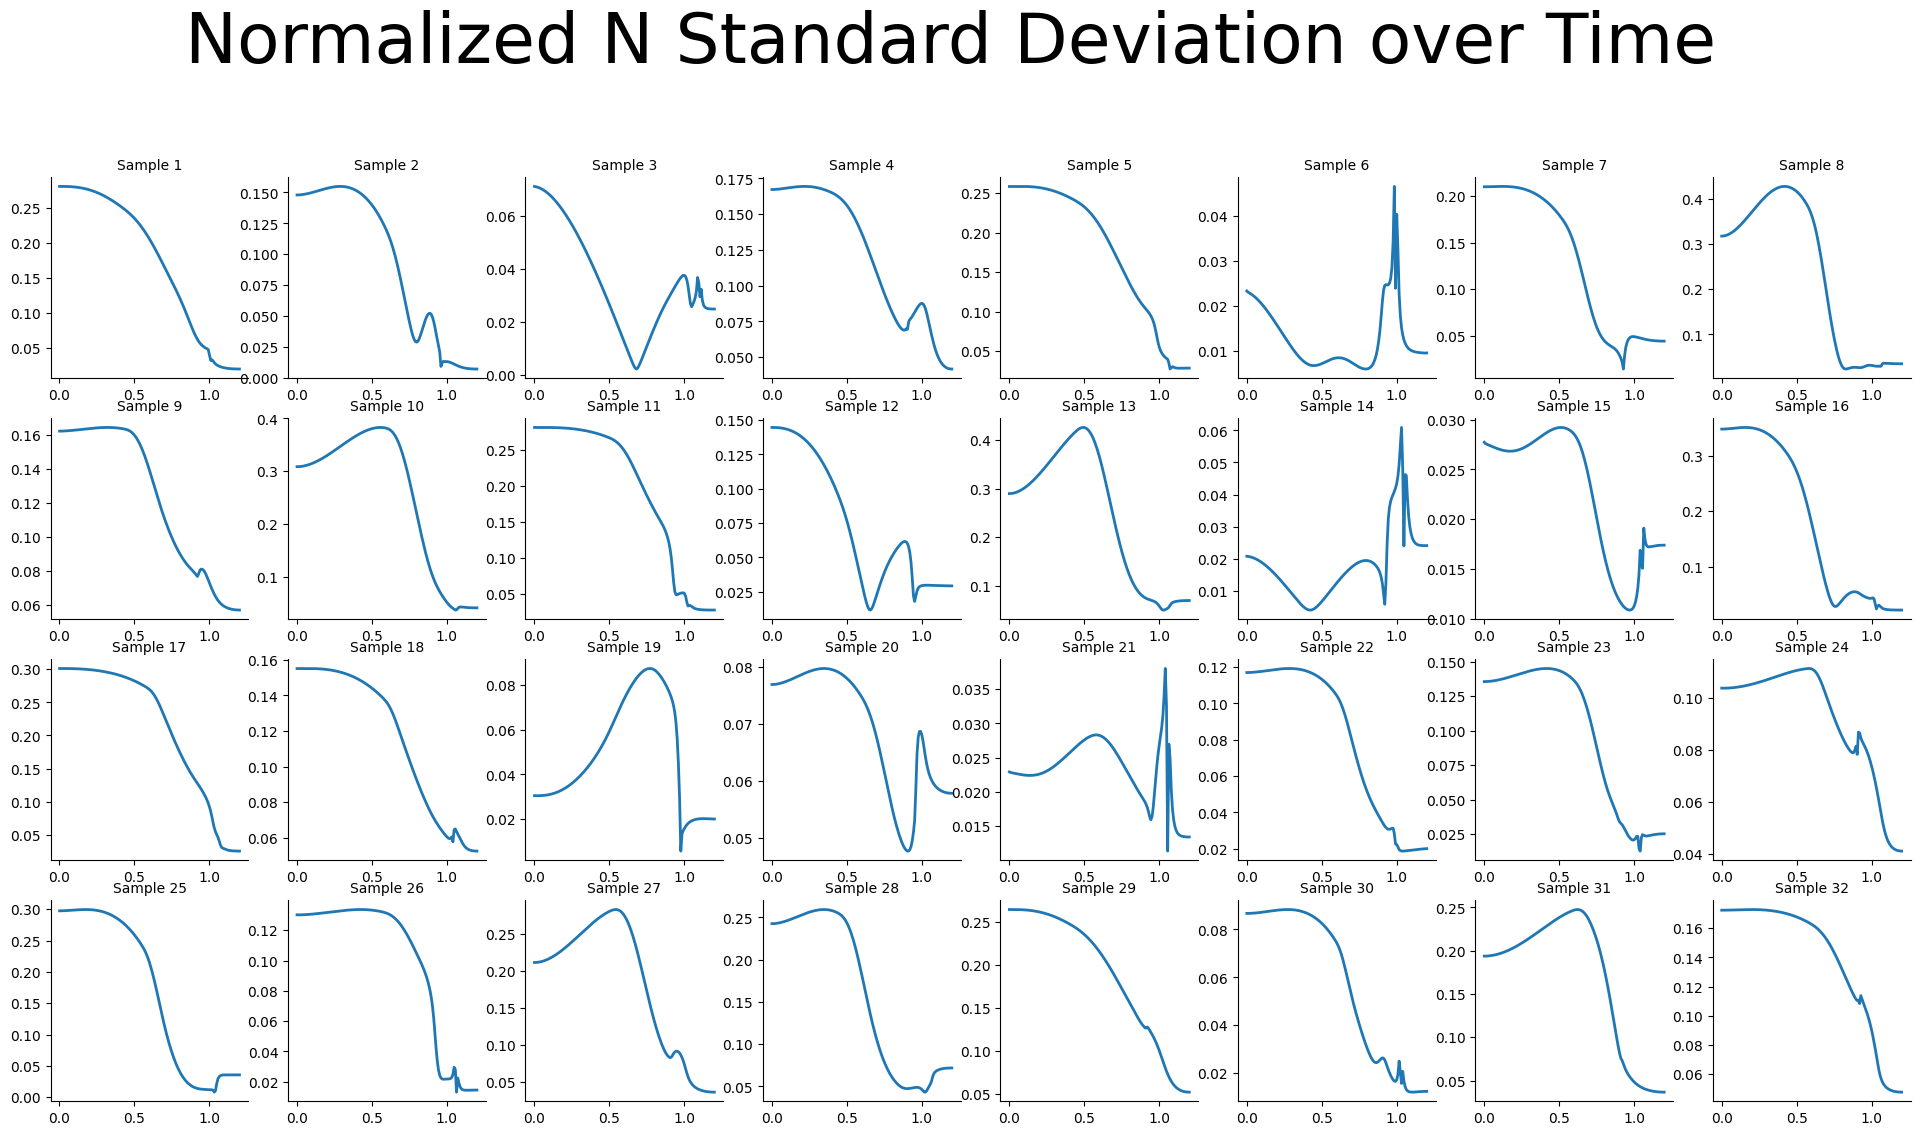

In [16]:
# plot 8 samples of N_results_g plot over time at last rho
#N std
rn = 8
rc = 4
Nnorm = N_results_g/N_results_g[:, :, 0].amax(dim=1).unsqueeze(1).unsqueeze(2)
Nstds = Nnorm.std(dim=2)
#print(Nstds)
fig, ax = plt.subplots(rc, rn, figsize=(3*rn, 3*rc))
for i in range(rc*rn):
	row = i // rn
	col = i % rn
	ax[row, col].plot(builder.rho.cpu().numpy(), Nstds[i, :].cpu().numpy(), linewidth=2)
	ax[row, col].set_title(f'Sample {i+1}', fontsize=10)
	ax[row, col].spines['top'].set_visible(False)
	ax[row, col].spines['right'].set_visible(False)
fig.suptitle("Normalized N Standard Deviation over Time", fontsize=50, y=1.02)
 

Text(0.5, 1.02, 'Initial Density Diff From Mean Density')

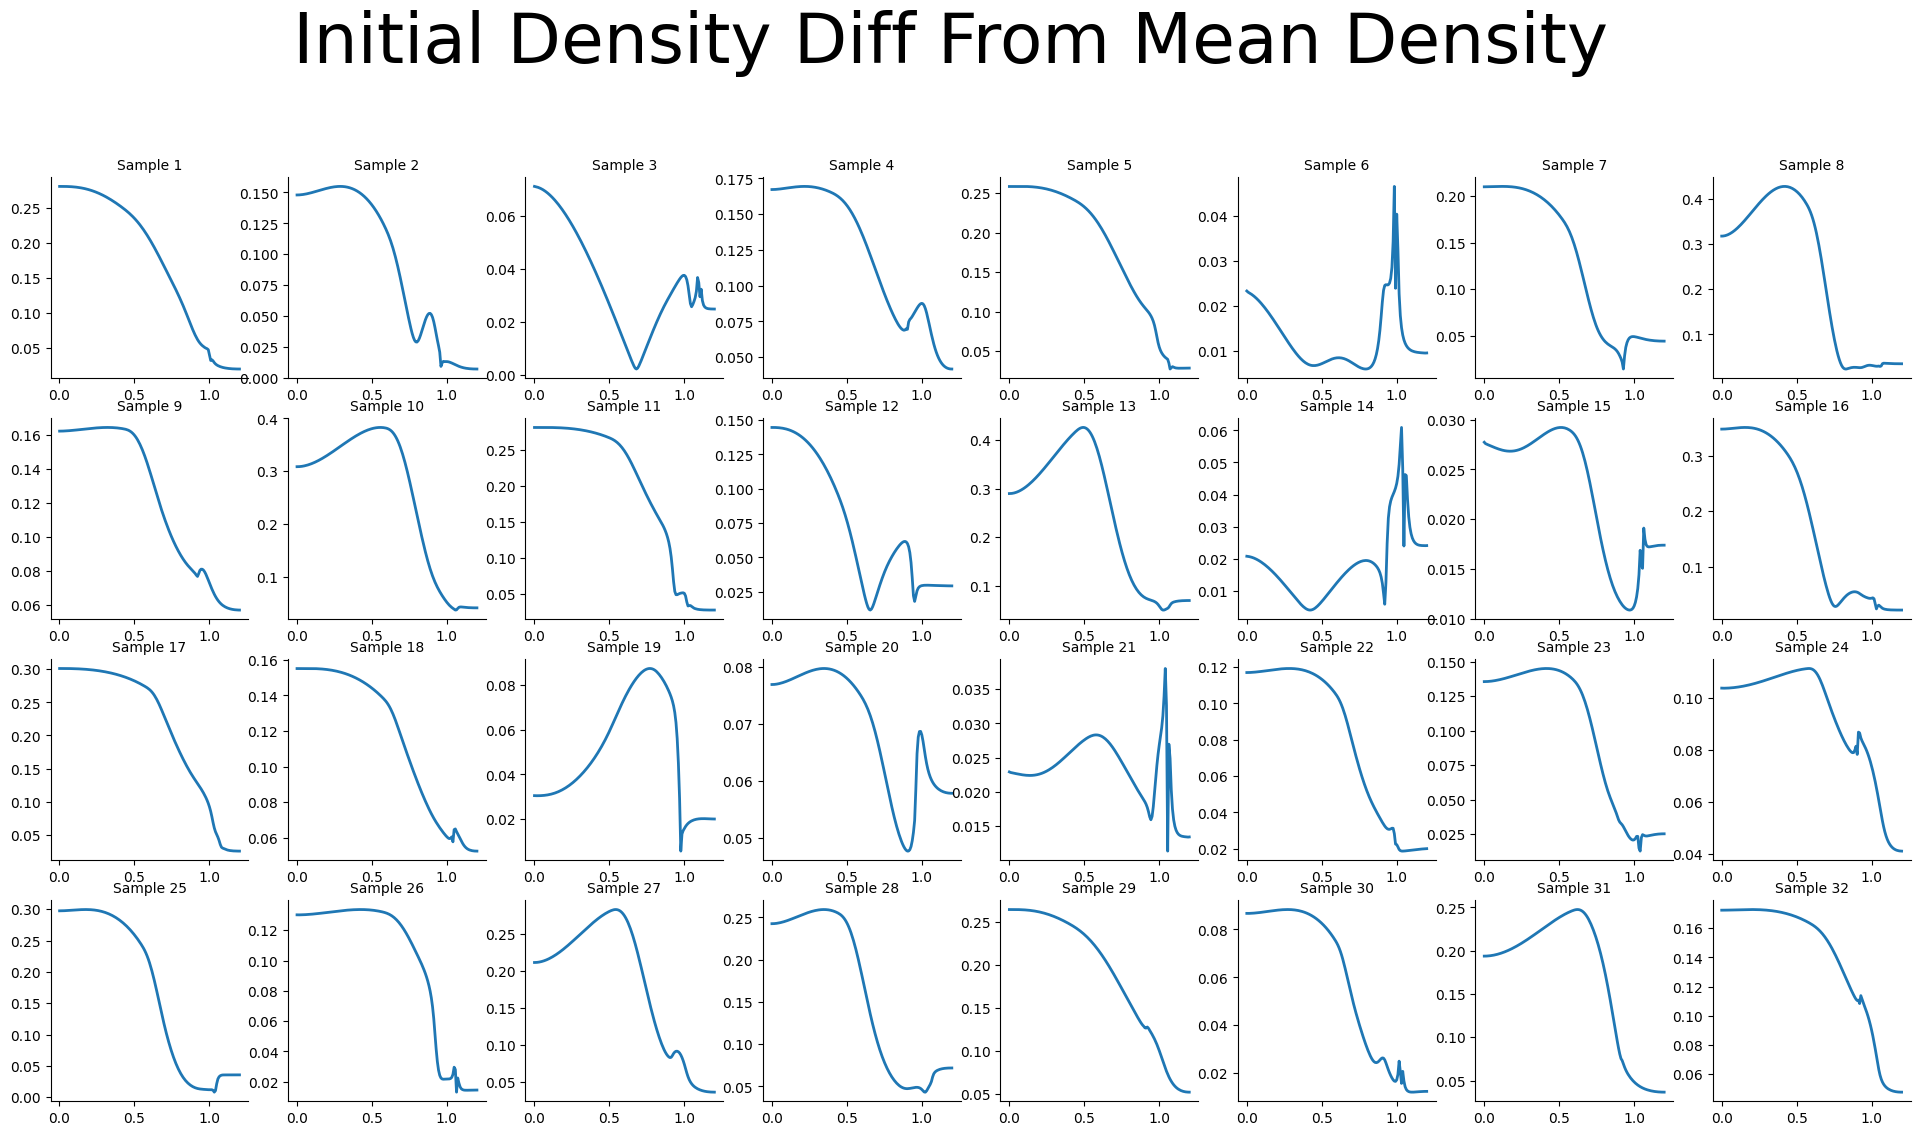

In [17]:
# plot 8 samples of N_results_g plot over time at last rho
# N mean diff
rn = 8
rc = 4
Nnorm = N_results_g/N_results_g[:, :, 0].amax(dim=1).unsqueeze(1).unsqueeze(2)
Nmean = Nnorm.mean(dim=2)
Ndiff = Nnorm[:, :, 0] - Nmean
#print(Nstds)
fig, ax = plt.subplots(rc, rn, figsize=(3*rn, 3*rc))
for i in range(rc*rn):
	row = i // rn
	col = i % rn
	ax[row, col].plot(builder.rho.cpu().numpy(), Nstds[i, :].cpu().numpy(), linewidth=2)
	ax[row, col].set_title(f'Sample {i+1}', fontsize=10)
	ax[row, col].spines['top'].set_visible(False)
	ax[row, col].spines['right'].set_visible(False)
fig.suptitle(f"Initial Density Diff From Mean Density", fontsize=50, y=1.02)
 

Text(0.5, 1.02, 'N Density over Time at Rho = 0.001')

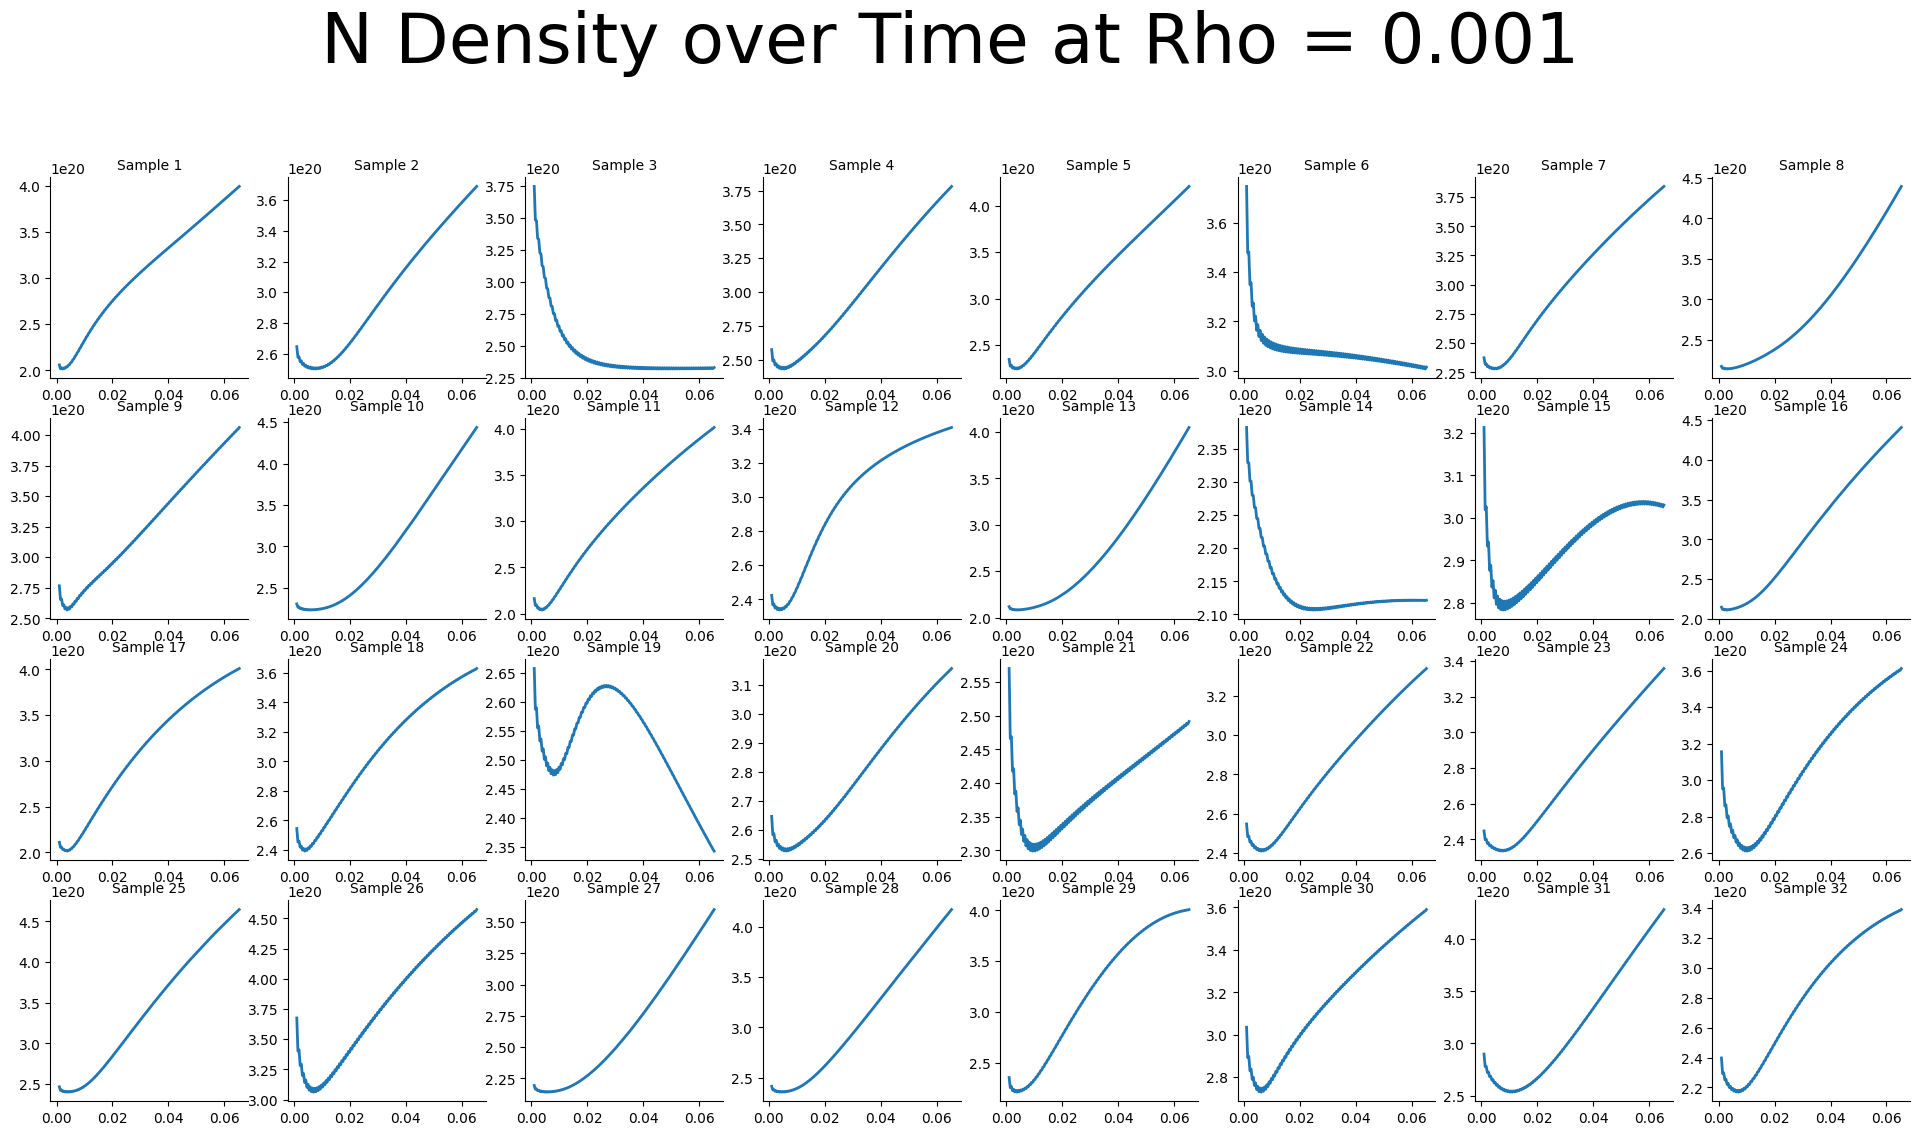

In [18]:
# plot 8 samples of N_results_g plot over time at last rho
rn = 8
rc = 4
frac=0
nr = builder.rho.shape[0]
fig, ax = plt.subplots(rc, rn, figsize=(3*rn, 3*rc))
for i in range(rc*rn):
	row = i // rn
	col = i % rn
	ax[row, col].plot(builder.time.cpu().numpy(), N_results_g[i, int(nr*frac), :].cpu().numpy(), linewidth=2)
	ax[row, col].set_title(f'Sample {i+1}', fontsize=10)
	ax[row, col].spines['top'].set_visible(False)
	ax[row, col].spines['right'].set_visible(False)
fig.suptitle(f"N Density over Time at Rho = {builder.rho.cpu().numpy()[int(nr*frac)]:.3f}", fontsize=50, y=1.02)
 